<a href="https://colab.research.google.com/github/SarkisyanSergey/NLP_Pipiline/blob/main/NLP_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
# установим  пакеты
!pip install pysrt
!pip install spacy

In [ ]:
# импортируем библиотеки
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,
                                     StratifiedShuffleSplit,
                                     GridSearchCV
                                     )
from sklearn.pipeline import (Pipeline,
                              FeatureUnion
                              )

from sklearn.metrics import (classification_report,
                             f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay
                             )
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import (TfidfVectorizer,
                                             CountVectorizer
                                             )
from sklearn.base import (BaseEstimator,
                          TransformerMixin
                          )
import pysrt
import spacy
import nltk
from nltk.corpus import stopwords

In [ ]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Трансформер для выбора одного столбца для выполнения
    дополнительных преобразований.
    Использование в текстовых столбцах
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Трансформер для выбора одного столбца для выполнения
    дополнительных преобразований.
    Использование в числовых столбцах
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

##Загрузка данных

###Загружаем данные по фильмам

In [ ]:
#загружаем данные по фильмам
PATH = '/content/drive/My Drive/Colab Notebooks/datasets'
df = pd.read_excel(f'{PATH}/movies_labels.xlsx', index_col='id')
df.head(3)

,Movie,Level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2


In [ ]:
# определим какие целевые метки содержат данные
df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

In [ ]:
# определим словарь меток с кодированием значений
label_dict = {'A2': 1,
              'A2/A2+': 1,
              'B1': 2,
              'A2/A2+, B1': 2,
              'B2': 3,
              'B1, B2': 3,
              'C1': 4}
# заменим метки числовыми значениями
df['Level'] = df['Level'].replace(label_dict)

In [ ]:
# удалим дубликаты
df = df.drop_duplicates()
df.shape

(238, 2)

###Загрузка субтитров

In [ ]:
#Количество названий фильмов в папке с субтитрами
films_name = os.listdir(f'{PATH}/SBTL1')
print(len(films_name))

172


In [ ]:
# проверим для скольких фильмов, имеющих метку из таблицы, предоставлены субтитры
films_filtr = set(films_name) & set(df['Movie'] + '.srt')
len(films_filtr)

161

In [ ]:
def load_subs(film):
  """загружет субтитры"""
  if f'{film}.srt' not in set(films_name):
    return None
  try:
    subs = pysrt.open(f'{PATH}/SBTL1/{film}.srt')
  except:
    subs = pysrt.open(f'{PATH}/SBTL1/{film}.srt', encoding='iso-8859-1')
  return subs

In [ ]:
%%time
#загружаем субтитры
df['subs'] = df['Movie'].apply(load_subs)

CPU times: user 9.1 s, sys: 193 ms, total: 9.3 s
Wall time: 14.5 s


In [ ]:
df['subs']

id
0      [1\n00:00:55,279 --> 00:01:07,279\n<font color...
1      [1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n...
2      [1\n00:00:15,089 --> 00:00:21,229\nResync: Xen...
3      [1\n00:00:17,610 --> 00:00:22,610\n- <i><font ...
4      [1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co...
                             ...                        
236                                                 None
237                                                 None
238                                                 None
239                                                 None
240                                                 None
Name: subs, Length: 238, dtype: object

In [ ]:
#удаляем пропуски
df = df.dropna().reset_index(drop=True)

In [ ]:
df

,Movie,Level,subs
0,10_Cloverfield_lane(2016),2,"[1\n00:00:55,279 --> 00:01:07,279\n<font color..."
1,10_things_I_hate_about_you(1999),2,"[1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n..."
2,A_knights_tale(2001),3,"[1\n00:00:15,089 --> 00:00:21,229\nResync: Xen..."
3,A_star_is_born(2018),3,"[1\n00:00:17,610 --> 00:00:22,610\n- <i><font ..."
4,Aladdin(1992),1,"[1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co..."
...,...,...,...
157,Suits.S03E06.720p.HDTV.x264-mSD,4,"[1\n00:00:01,383 --> 00:00:02,751\nI lost Ava ..."
158,Suits.S03E07.HDTV.x264-mSD,4,"[1\n00:00:00,052 --> 00:00:01,352\nPreviously ..."
159,Suits.S03E08.480p.HDTV.x264-mSD,4,"[1\n00:00:01,436 --> 00:00:03,028\nI get Ava H..."
160,Suits.S03E09.480p.HDTV.x264-mSD,4,"[1\n00:00:00,024 --> 00:00:01,478\nPreviously ..."


###Оценка дисбаланса классов уровней

In [ ]:
df['Level'].value_counts()

2    55
4    39
3    37
1    31
Name: Level, dtype: int64

###Разделение данных на обучающую и тестовую выборки

In [ ]:
STATE = 0
df_train, df_test = train_test_split(df, random_state=STATE,
                                    test_size=0.25,
                                    stratify=df['Level'])
X = df_train.drop(['Level','Movie'], axis=1)
y = df_train['Level']
X_test = df_test.drop(['Level','Movie'], axis=1)
y_test = df_test['Level']
print(f'Размер обучающей выборки: {X.shape, y.shape}')
print(f'Размер тестовой выборки: {X_test.shape, y_test.shape}')

Размер обучающей выборки: ((121, 1), (121,))
Размер тестовой выборки: ((41, 1), (41,))


###Очищаем субтитры

In [ ]:
# зададим регулярные выражения для очистки текста
HTML = r'<.*?>' # html тэги меняем на пробел
TAG = r'{.*?}' # тэги меняем на пробел
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # комменты в скобках меняем на пробел
LETTERS = r'[^\w\s]' # все что не буквы меняем на пробел
SPACES = r'([ ])\1+' # повторяющиеся пробелы меняем на один пробел
DOTS = r'[\.]+' # многоточие меняем на точку
SYMB = r"[^\w\d'\s]" # знаки препинания кроме апострофа
def clean_subs(subs):
  """очистки субтитров"""
  subs = subs[1:] # удаляем первый рекламный субтитр
  txt = re.sub(HTML, ' ', subs.text) # html тэги меняем на пробел
  txt = re.sub(COMMENTS, ' ', txt) # комменты в скобках меняем на пробел
  txt = re.sub(LETTERS, ' ', txt) # все что не буквы меняем на пробел
  txt = re.sub(DOTS, r'.', txt) # многоточие меняем на точку
  txt = re.sub(SPACES, r'\1', txt) # повторяющиеся пробелы меняем на один пробел
  txt = re.sub(SYMB, '', txt) # знаки препинания кроме апострофа на пустую строку
  txt = re.sub('www', '', txt) # кое-где остаётся www, то же меняем на пустую строку
  txt = txt.lstrip().rstrip().replace("\n","") # обрезка пробелов слева
  txt = txt.encode('ascii', 'ignore').decode() # удаляем все что не ascii символы
  txt = txt.lower() # текст в нижний регистр
  txt = ' '.join(txt.split())
  return txt

In [ ]:
%%time
X['subs'] = X['subs'].apply(clean_subs)
X['subs']

CPU times: user 1.4 s, sys: 12.8 ms, total: 1.41 s
Wall time: 1.82 s


112    hey hey whoa whoa whoa whoa ma am ma am please...
43     joy do you ever look at someone and wonder wha...
93     when the chips arestartin to fall just when th...
89     bagheera many strange talesare told of this ju...
87     to be true shakespeare said journeys end in lo...
                             ...                        
28     rhythmic thumping musicplaying my planetarraki...
59     there was a boya very strange enchanted boythe...
131    they said it would which isn t quite the same ...
69     come on hurry get in and don t come out daniel...
129    oh my god that s impossible i ll take it up th...
Name: subs, Length: 121, dtype: object

###Загрузка словарей

In [ ]:
def convert_to_dict(df):
  """конвертирует словари"""
  df.loc[-1] = df.columns.values
  df.sort_index(inplace=True)
  df.reset_index(drop=True, inplace=True)
  df.columns = [0]
  df[0]=df[0].str.split(' ').str[0]
  df[0] =df[0].str.lower()
  df[0].replace(LETTERS,'',regex=True, inplace = True)

levels = ['A2','B1','B2','C1']
vlev = {}
for level in levels:
  f = f'{PATH}/Oxford_CEFR_level/{level}.csv'
  df = pd.read_csv(f)
  convert_to_dict(df)
  vlev[level]=set(list(df[0]))

###Оценка дисбаланса классов словарей

In [ ]:
for level in levels:
  print(level,'=',len(vlev[level]))

A2 = 865
B1 = 806
B2 = 727
C1 = 1314


###Добавление признаков

In [ ]:
def count_percent_words_dictionar(sub):
  """считает процент лем в словарях"""
  nlp = spacy.load('en_core_web_sm' )
  doc = nlp(sub)
  lms = set([token.lemma_ for token in doc])
  lem_per = [(len(lms&vlev[level])/len(lms))*100 for level in levels]
  return lem_per

In [ ]:
%%time
levpercent = [f'{_}+percent' for _ in levels]
X.loc[:,levpercent] = X['subs'].apply(count_percent_words_dictionar).to_list()
X

CPU times: user 4min 35s, sys: 5.57 s, total: 4min 40s
Wall time: 4min 51s


,subs,A2+percent,B1+percent,B2+percent,C1+percent
112,hey hey whoa whoa whoa whoa ma am ma am please...,16.354557,8.988764,6.242197,4.244694
43,joy do you ever look at someone and wonder wha...,18.719212,11.904762,7.799672,3.119869
93,when the chips arestartin to fall just when th...,11.279826,6.561822,4.013015,2.114967
89,bagheera many strange talesare told of this ju...,18.768920,10.191726,7.467205,3.329970
87,to be true shakespeare said journeys end in lo...,14.373602,9.284116,6.152125,2.740492
...,...,...,...,...,...
28,rhythmic thumping musicplaying my planetarraki...,14.078550,8.338369,7.129909,3.987915
59,there was a boya very strange enchanted boythe...,12.079701,7.098381,5.043587,2.926526
131,they said it would which isn t quite the same ...,16.083916,10.576923,6.730769,3.583916
69,come on hurry get in and don t come out daniel...,14.961307,9.630267,5.760963,3.783319


###Анализ признаков

In [ ]:
for lev in range(1,5):
  print(f'Level-{lev}')
  print(X[y==lev][levpercent].describe().round(2))
  print()

Level-1
       A2+percent  B1+percent  B2+percent  C1+percent
count       23.00       23.00       23.00       23.00
mean        15.52        8.90        6.30        3.42
std          2.22        1.38        1.27        1.03
min         11.28        6.42        4.01        2.11
25%         14.33        7.80        5.41        2.61
50%         16.02        8.99        6.12        3.33
75%         16.58        9.75        7.44        3.98
max         19.50       12.14        8.19        6.33

Level-2
       A2+percent  B1+percent  B2+percent  C1+percent
count       41.00       41.00       41.00       41.00
mean        15.37        9.11        6.48        3.33
std          1.69        1.13        1.17        0.70
min         12.08        6.57        4.75        1.23
25%         14.37        8.31        5.65        2.83
50%         15.13        9.14        6.34        3.43
75%         16.43       10.03        7.15        3.79
max         18.72       11.90        8.98        4.57

Level-3
  

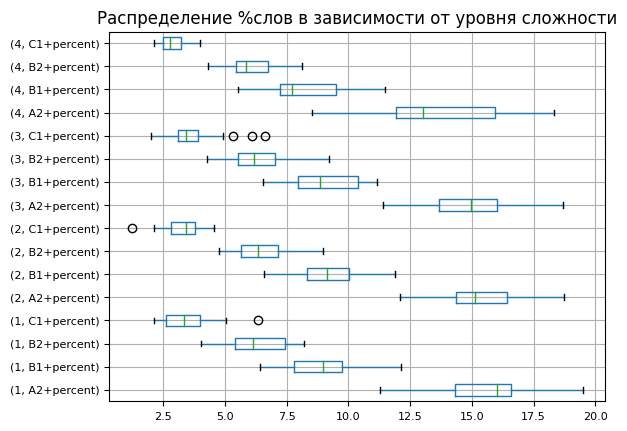

In [ ]:
title='Распределение %слов в зависимости от уровня сложности'
ax = X.groupby(y).boxplot(subplots=False,
                     fontsize=8,
                     vert=False,
                     grid =True,
                     )
ax.set_title(title)
plt.show()

Распределение уровня сложности слов почти не зависит от уровня сложности субтитров

##Выбор модели

###Выбор метрики качества
В связи с тем, что:в данных обнаружен дисбаланс классов;
в текущей задаче является важным как точность ('precision') так и полнота ('recall') предсказания модели;
лучшей метрикой для подгонки и оценки модели принимается средне-гармоническое точности и полноты - F1-мера. Для мультиклассификации будет использована взвешенная F1-мера (F1_weighted).

### Создание пайплана

In [ ]:
report = pd.DataFrame(columns = ['model',
                                 'classificator',
                                 'vectorizer',
                                 'hparams',
                                 'F1 score'
                                 ])

In [ ]:
a2 =  Pipeline([
                ('selector', NumberSelector(key='A2+percent')),
                ('standard', MinMaxScaler())
            ])
b1 =  Pipeline([
                ('selector', NumberSelector(key='B1+percent')),
                ('standard', MinMaxScaler())
            ])
b2 =  Pipeline([
                ('selector', NumberSelector(key='B2+percent')),
                ('standard', MinMaxScaler())
            ])
c1 =  Pipeline([
                ('selector', NumberSelector(key='C1+percent')),
                ('standard', MinMaxScaler())
            ])

In [ ]:
vects = [[('vec', CountVectorizer(stop_words='english')),
          {
           'features__text__vec__ngram_range': [(1,2),(2,2),(1,3)],
           'features__text__vec__min_df': [2,3,4]
           }
          ],
         [('vec', TfidfVectorizer(stop_words='english')),
{
           'features__text__vec__ngram_range': [(1,2),(2,2),(1,3)],
           'features__text__vec__min_df': [2,3,4]
           }
          ]]

clfs = [[SGDClassifier(random_state=STATE),
         {'classifier__alpha': [0.001, 0.01, 0.1]}
         ],
          [MultinomialNB(),
           {'classifier__alpha': [0.5, 1]}
         ]]

###Обучение моделей

In [ ]:
%%time
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=6,
                                                  test_size=0.25,
                                                  random_state=STATE)
for vec in vects:
  vecpipe = Pipeline([('selector', TextSelector(key='subs')),
                      vec[0]
                      ])
  vecpipe.fit_transform(X)
  featscountvector = FeatureUnion([('text', vecpipe),
                      ('A2+percent', a2),
                      ('B1+percent', b1),
                      ('B2+percent', b2),
                      ('C1+percent', c1),
                        ])

  feature_processing = Pipeline([('feats', featscountvector)])
  feature_processing.fit_transform(X)

  for clf in clfs:
    clfpipeline = Pipeline([
        ('features', featscountvector),
        ('classifier', clf[0]),
    ])
    hyperparameters = vec[1]|clf[1]
    clfpipegridcv = GridSearchCV(clfpipeline,
                                hyperparameters,
                                cv=stratified_shuffle_split,
                                scoring='f1_weighted'
                                )
    clfpipegridcv.fit(X, y)
    report.loc[len(report)]=[clfpipegridcv.best_estimator_,
                             str(clf[0]),
                             str(vec[0]),
                             str(clfpipegridcv.best_params_),
                             clfpipegridcv.best_score_
                             ]
report = report.sort_values(by='F1 score',ascending=False)
report.reset_index(drop= True , inplace= True )
report

CPU times: user 17min 56s, sys: 32.1 s, total: 18min 28s
Wall time: 18min 7s


,model,classificator,vectorizer,hparams,F1 score
0,"(FeatureUnion(transformer_list=[('text',\n ...",MultinomialNB(),"('vec', CountVectorizer(stop_words='english'))","{'classifier__alpha': 1, 'features__text__vec_...",0.615158
1,"(FeatureUnion(transformer_list=[('text',\n ...",SGDClassifier(random_state=0),"('vec', TfidfVectorizer(stop_words='english'))","{'classifier__alpha': 0.01, 'features__text__v...",0.576102
2,"(FeatureUnion(transformer_list=[('text',\n ...",SGDClassifier(random_state=0),"('vec', CountVectorizer(stop_words='english'))","{'classifier__alpha': 0.1, 'features__text__ve...",0.544789
3,"(FeatureUnion(transformer_list=[('text',\n ...",MultinomialNB(),"('vec', TfidfVectorizer(stop_words='english'))","{'classifier__alpha': 0.5, 'features__text__ve...",0.421534


In [ ]:
#выбираем и обучаем лучшую модель на всем наборе данных
clf = report['model'].loc[0]
clf.fit(X, y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='subs')),
                                                                 ('vec',
                                                                  CountVectorizer(min_df=3,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  stop_words='english'))])),
                                                ('A2+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='A2+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('B1+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B1+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('B2+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B2+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('C1+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='C1+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())]))])),
                ('classifier', MultinomialNB(alpha=1))])

##Оценка модели на тестовой  выборке

In [ ]:
X_test['subs'] = X_test['subs'].apply(clean_subs)
X_test.loc[:,levpercent] = X_test['subs'].apply(count_percent_words_dictionar).to_list()

              precision    recall  f1-score   support

           1       1.00      0.12      0.22         8
           2       0.48      0.71      0.57        14
           3       0.55      0.67      0.60         9
           4       1.00      0.80      0.89        10

    accuracy                           0.61        41
   macro avg       0.76      0.58      0.57        41
weighted avg       0.72      0.61      0.59        41



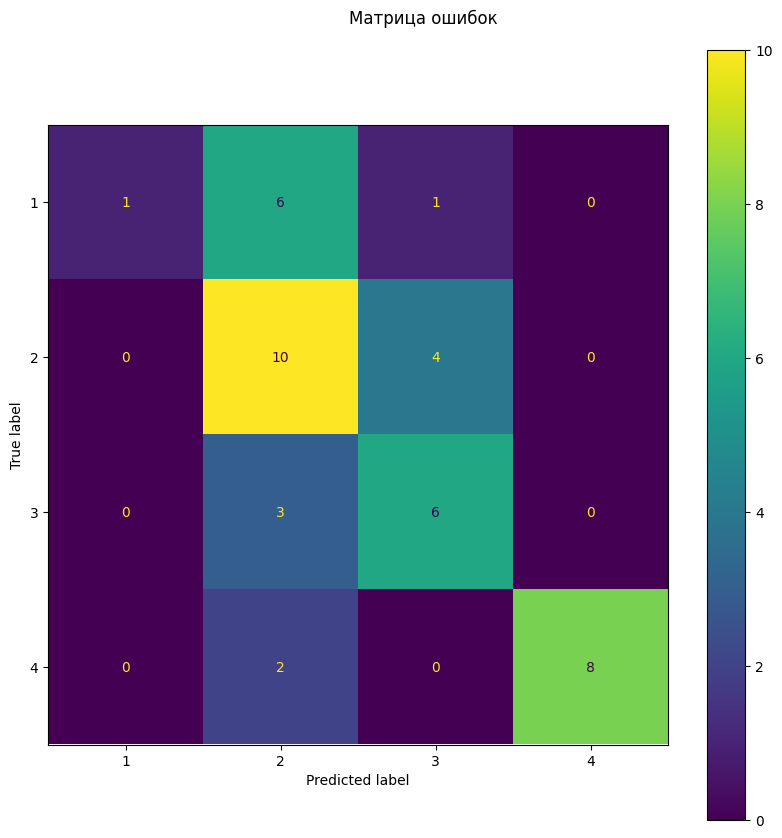

In [ ]:
def plot_confusion_matrix(y_test, y_preds, model):
  """строит матрицу ошибок"""
  fig, ax = plt.subplots(figsize=(10,10))
  cm = confusion_matrix(y_test, y_preds)
  cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
  cmp.plot(ax=ax)
  plt.suptitle('Матрица ошибок', y=0.92)
  plt.show()
predictions =clf.predict(X_test)
# выведем классификационную таблицу и матрицу ошибок
print(classification_report(y_test, predictions))
plot_confusion_matrix(y_test, predictions, clf)

###Выводы по результатам работы модели
Из оценки классификатора на тестовой выборке можно сделать следующие выводы:

Модель MultinomialNB() чаще всего ошибается на граничных метках.
Взвешенная метрика F1-weighted на тестовой выборке составила 0.59.

##Выводы
В ходе работы было выполнено:

Загрузка необходимых библиотек;
загрузка и ознакомление с данными (загружены субтитры, фильмы с метками уровня сложности, классический словарь Oxford с 5000 словами);
предобработка данных (очистка от дубликатов, проверка наличия разметки для обучающих данных, определение исходного количества представленных данных, очитска текста субтитров, разбивка на обучающую и тестовую выборки);
Выбора метода препроцессинг данных, а именно преобразование текство субтитров с компактную разреженную матрицу с помощью CountVectorizer,  TfidfVectorizer.
Добавление дополнительных признаков- количество уникальных лемм (слов основной формы), содержащихся в каждом тексте субтитров согласно уровню сложности по классичесокму словарю Oxford;
обоснование использования метрики качества F1-weighted;
Выбор модели-классификатора MultinomialNB, SGDClassifier с побором гиперпараметров. Оценка модели на тестовой выборке.